In [95]:
import os
import sys
print(sys.executable)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('..')
from get_data import FILE_NAMES

%matplotlib inline

/home/andreib/miniconda/envs/csc2305/bin/python


In [96]:
%pwd

'/home/andreib/work/numerics-from-scratch/csc2305/project/analysis'

In [97]:
# Each point in the reconstruction is just a 3D point, so it has three parameters.
PARAMS_PER_POINT = 3
# Each camera has a 6 DoF 3D rigid pose, plus three intrinsic parameters: focal length (same x and y),
# and two radial distorsion params.
PARAMS_PER_CAMERA = 6 + 3

EXP_ROOT = os.path.join('..', 'experiments', '00')
assert len(os.listdir(EXP_ROOT)), "The experiment directory should not be empty."

In [98]:
files = os.listdir(EXP_ROOT)
seq = 'trafalgar'

print(FILE_NAMES[seq])

['problem-21-11315-pre.txt', 'problem-39-18060-pre.txt', 'problem-50-20431-pre.txt', 'problem-126-40037-pre.txt', 'problem-138-44033-pre.txt', 'problem-161-48126-pre.txt', 'problem-170-49267-pre.txt', 'problem-174-50489-pre.txt', 'problem-193-53101-pre.txt', 'problem-201-54427-pre.txt', 'problem-206-54562-pre.txt', 'problem-215-55910-pre.txt', 'problem-225-57665-pre.txt', 'problem-257-65132-pre.txt']


In [110]:
from collections import namedtuple

ExperimentParams = namedtuple(
    'ExperimentParams', 
    ['min_type', 'tr_strategy', 'dogleg_type', 'linear_solver_type', 'line_search_type', 'nlcg_type'])

def parse_meta(meta_fpath):
    with open(meta_fpath, 'r') as meta_file:
        raw_line = meta_file.readlines()[0]
        #     TRUST_REGION,LEVENBERG_MARQUARDT,TRADITIONAL_DOGLEG,DENSE_SCHUR,LBFGS,FLETCHER_REEVES
        return ExperimentParams(*(raw_line.strip().split(',')))

def parse_raw(raw_fpath):
    n_residuals = -1
    with open(raw_fpath, 'r') as raw_file:
        for line in raw_file.readlines():
            if 'residuals' in line.lower():
                n_residuals = int(line.split()[1])

    if -1 == n_residuals:
        raise ValueError("Could not parse raw file!")
    return n_residuals

In [120]:
def ap_list(m, key, element):
    if key not in m:
        m[key] = []
    m[key].append(element)

def load_files(root):
    files = os.listdir(root)
    
    agg = {
        category: { } for category in ['lm', 'dogleg', 'linesearch']
    }
    
    for file in files:
        if file.endswith(".csv"):
            _, seq_name, _, n_images_s, n_points_s, *_ = file.split('-')
            n_images = int(n_images_s)
            n_points = int(n_points_s)
            
            params = parse_meta(os.path.join(root, file.replace('.csv', '.meta.txt')))
            n_residuals = parse_raw(os.path.join(root, file.replace('.csv', '.raw_summary.txt')))

            df = pd.read_csv(os.path.join(root, file))
            iterations = len(df)
            final_cost = df['cost'].iloc[-1]
            final_seconds = df['cumulative_time_in_seconds'].iloc[-1]
            
            method_name = None
            if params.min_type == 'TRUST_REGION':
                if params.tr_strategy == 'LEVENBERG_MARQUARDT':
                    c = 'lm'
                    method_name = "lm-" + str(params.linear_solver_type)
                else:
                    c = 'dogleg'
                    method_name = "dogleg-" + str(params.dogleg_type) + "-" + str(params.linear_solver_type)
            else:
                raise ValueError("Not supported yet.")
                
            ap_list(agg[c], 'method', method_name)
            ap_list(agg[c], 'n_images', n_images)
            ap_list(agg[c], 'n_points', n_points)
            ap_list(agg[c], 'n_params', n_points * PARAMS_PER_POINT + n_images * PARAMS_PER_CAMERA)
            ap_list(agg[c], 'iterations', iterations)        
            ap_list(agg[c], 'final_cost', final_cost)
            ap_list(agg[c], 'normalized_final_cost', final_cost * 1.0 / n_residuals)
            ap_list(agg[c], 'time_seconds', final_seconds)
        
    return {key: pd.DataFrame(vals) for (key, vals) in agg.items()}

data = load_files(EXP_ROOT)

In [121]:
data['lm']

,final_cost,iterations,method,n_images,n_params,n_points,normalized_final_cost,time_seconds
0,89359.8,47,lm-DENSE_SCHUR,193,161040,53101,0.227349,15.626000
1,60439.2,9,lm-DENSE_SCHUR,39,54531,18060,0.475517,0.630852
2,91541.4,50,lm-CGNR,201,165090,54427,0.228924,186.116000
3,84387.6,44,lm-SPARSE_NORMAL_CHOLESKY,161,145827,48126,0.231742,35.552000
4,92136.1,18,lm-CGNR,126,121245,40037,0.310582,36.022100
5,89359.8,47,lm-SPARSE_SCHUR,193,161040,53101,0.227349,11.834600
6,87041.8,40,lm-SPARSE_NORMAL_CHOLESKY,138,133341,44033,0.262334,30.006300
7,30378.6,11,lm-CGNR,21,34134,11315,0.416659,1.287750
8,91301.1,52,lm-SPARSE_SCHUR,225,175020,57665,0.218819,14.686600
9,60439.2,9,lm-SPARSE_NORMAL_CHOLESKY,39,54531,18060,0.475517,2.375260


In [126]:
x_pretty = {
    'n_points': 'Number of 3D points',
    'n_images': 'Number of input images',
    'n_params': 'Total number of parameters',
}

y_pretty = {
    'iterations': "Iterations to convergence",
    'time_seconds': "Total run time (seconds)",
    'final_cost': "Total final solution residual (px)",
    'normalized_final_cost': "Mean final solution residual (px)",
}

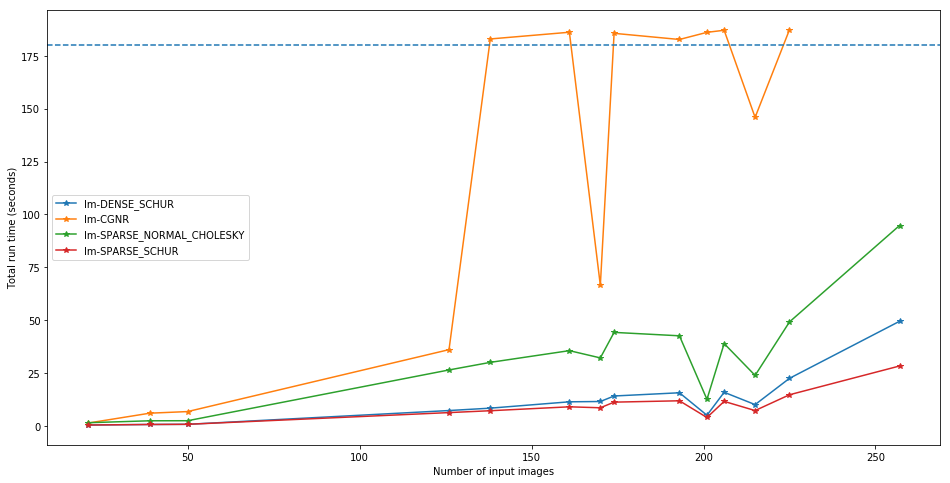

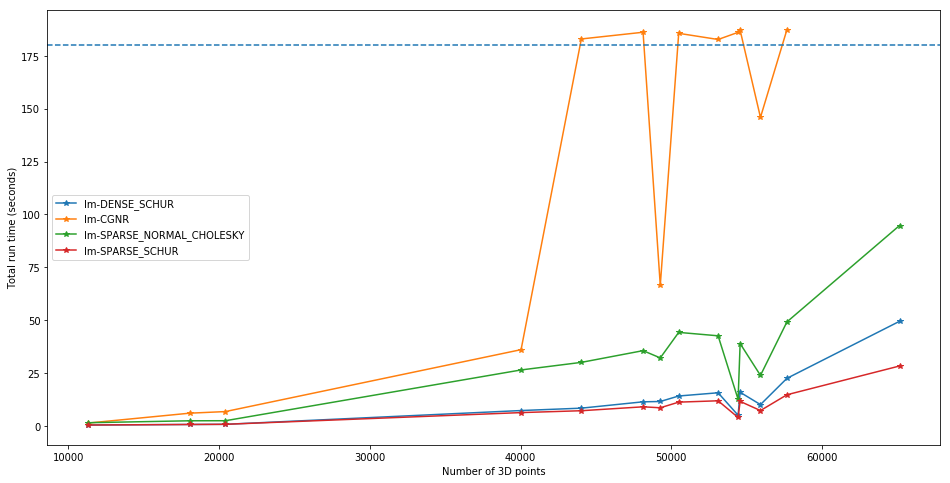

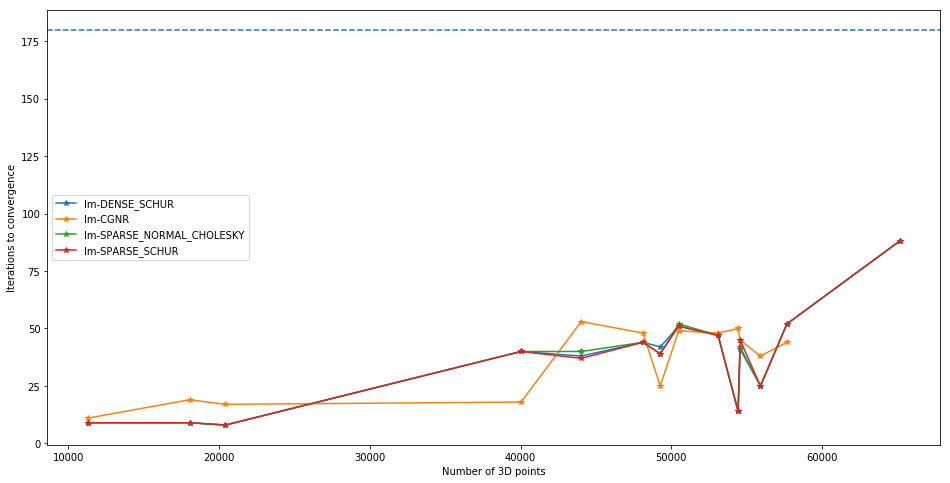

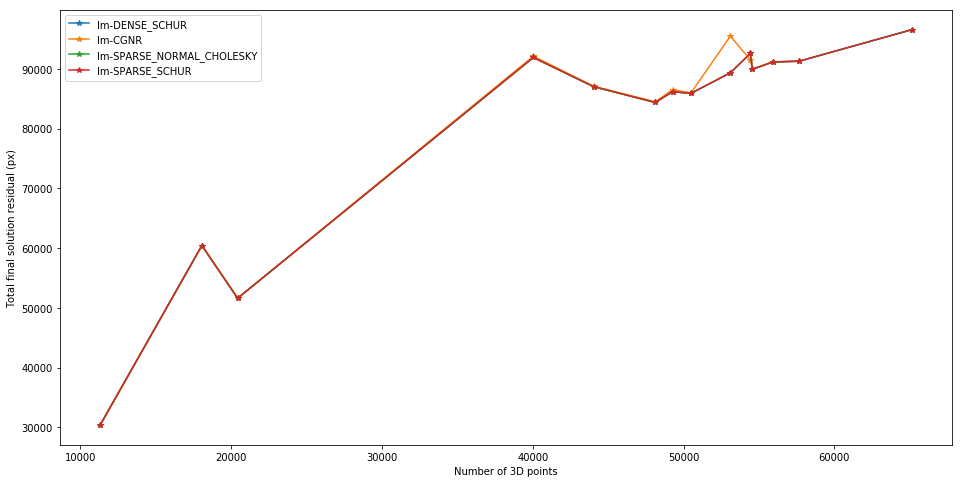

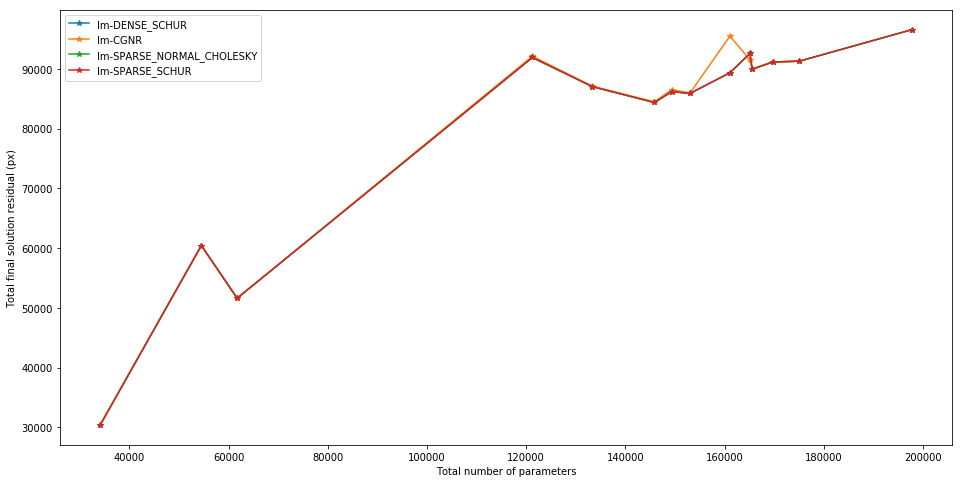

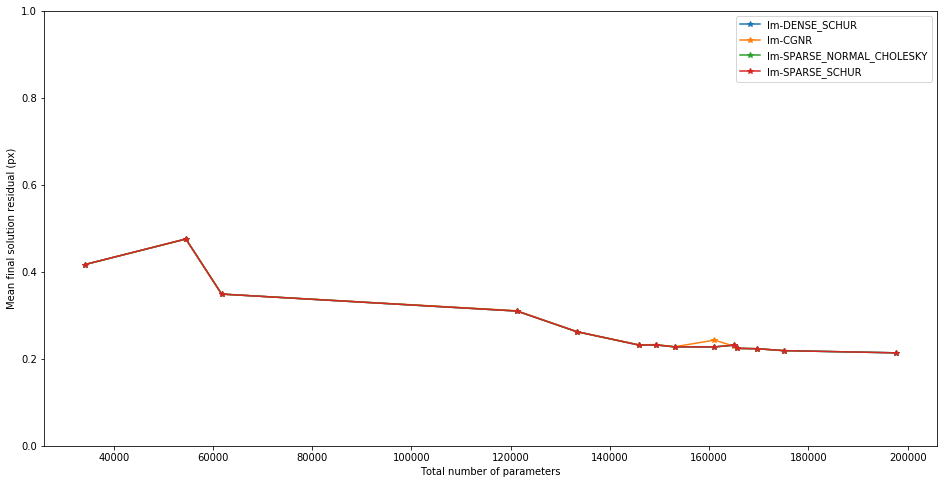

In [127]:
def plot_category(category, x_axis='n_images', y_axis='time_seconds', **kw):
    frame = data[category]
    methods = frame['method'].unique()

    plt.figure(figsize=(16,8))
    ax = plt.gca()
    for m in methods:
        frame[frame['method'] == m].sort_values(by='n_images').plot(x_axis, y_axis, linestyle='-',
                                                                    marker='*',
                                                                    ax=ax, label=m)
    ax.set_xlabel(x_pretty[x_axis])
    ax.set_ylabel(y_pretty[y_axis])
    
    top_hline = kw.get('top')
    if top_hline is not None:
        ax.axhline([top_hline], linestyle='--')
    
    if 'normalized' in y_axis:
        ax.set_ylim([0.0, 1.0])

    # Calling this in the end ensures proper positioning.
    ax.legend()
    
# TODO(andreib): Little skull icons for any marker over 'top'.
plot_category('lm', 'n_images', 'time_seconds', top=180)
plot_category('lm', 'n_points', 'time_seconds', top=180)
plot_category('lm', 'n_points', 'iterations', top=180)
plot_category('lm', 'n_points', 'final_cost', top=None)
plot_category('lm', 'n_params', 'final_cost', top=None)
plot_category('lm', 'n_params', 'normalized_final_cost', top=None)